In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Load the dataset
data = pd.read_csv('forestfires.csv')

data = data.dropna()

# Numerical features
numerical_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

# Categorical features
categorical_features = ['month', 'day', 'dayfri', 'daymon', 'daysat', 'daysun', 'daythu', 
                        'daytue', 'daywed', 'monthapr', 'monthaug', 'monthdec', 'monthfeb', 
                        'monthjan', 'monthjul', 'monthjun', 'monthmar', 'monthmay', 'monthnov', 
                        'monthoct', 'monthsep', 'size_category']

In [2]:
# Basic statistics of numerical features
numerical_data = data[numerical_features]
print(numerical_data.describe())

             FFMC         DMC          DC         ISI        temp          RH  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean    90.644681  110.872340  547.940039    9.021663   18.889168   44.288201   
std      5.520111   64.046482  248.066192    4.559477    5.806625   16.317469   
min     18.700000    1.100000    7.900000    0.000000    2.200000   15.000000   
25%     90.200000   68.600000  437.700000    6.500000   15.500000   33.000000   
50%     91.600000  108.300000  664.200000    8.400000   19.300000   42.000000   
75%     92.900000  142.400000  713.900000   10.800000   22.800000   53.000000   
max     96.200000  291.300000  860.600000   56.100000   33.300000  100.000000   

             wind        rain         area  
count  517.000000  517.000000   517.000000  
mean     4.017602    0.021663    12.847292  
std      1.791653    0.295959    63.655818  
min      0.400000    0.000000     0.000000  
25%      2.700000    0.000000     0.000000  


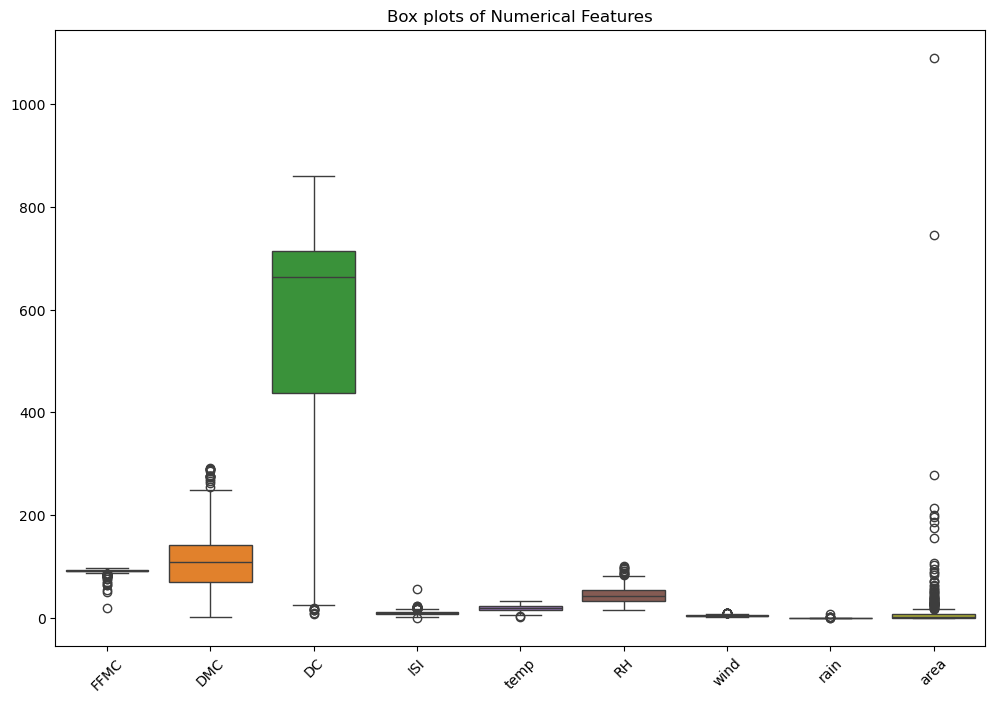

In [3]:
# Create box plots for numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_features])
plt.title('Box plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Function to remove outliers based on IQR
def remove_outliers_iqr(data, features):
    filtered_data = data.copy()
    for feature in features:
        Q1 = np.percentile(filtered_data[feature], 25)
        Q3 = np.percentile(filtered_data[feature], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = filtered_data[(filtered_data[feature] >= lower_bound) & (filtered_data[feature] <= upper_bound)]
    return filtered_data

# Remove outliers based on IQR
data = remove_outliers_iqr(data, numerical_features)

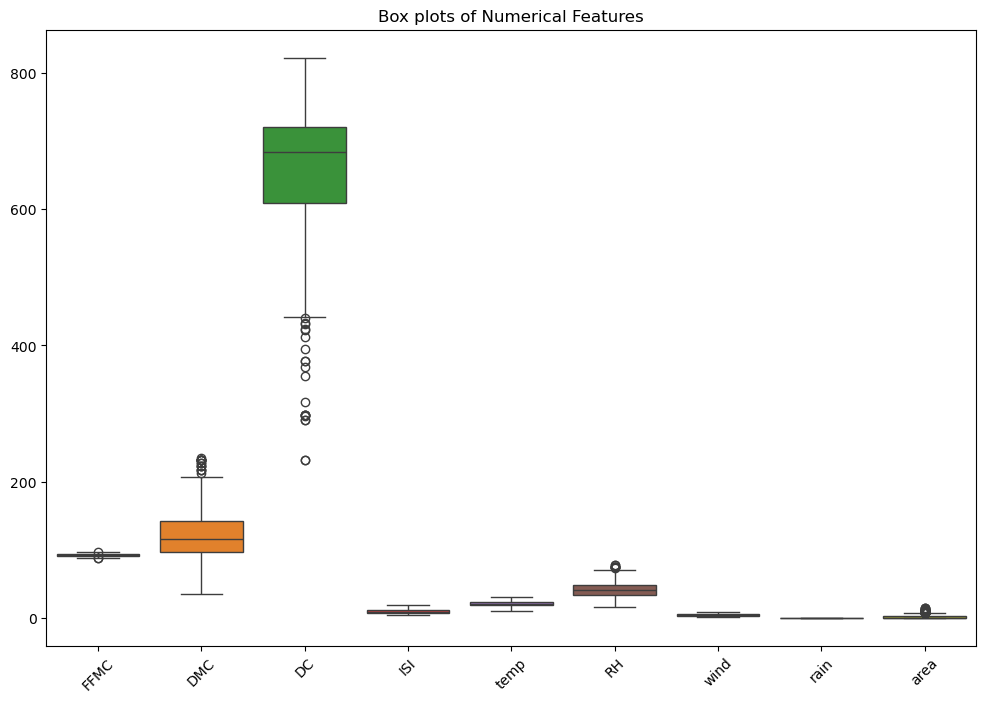

In [5]:
# Create box plots for numerical features without outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_features])
plt.title('Box plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

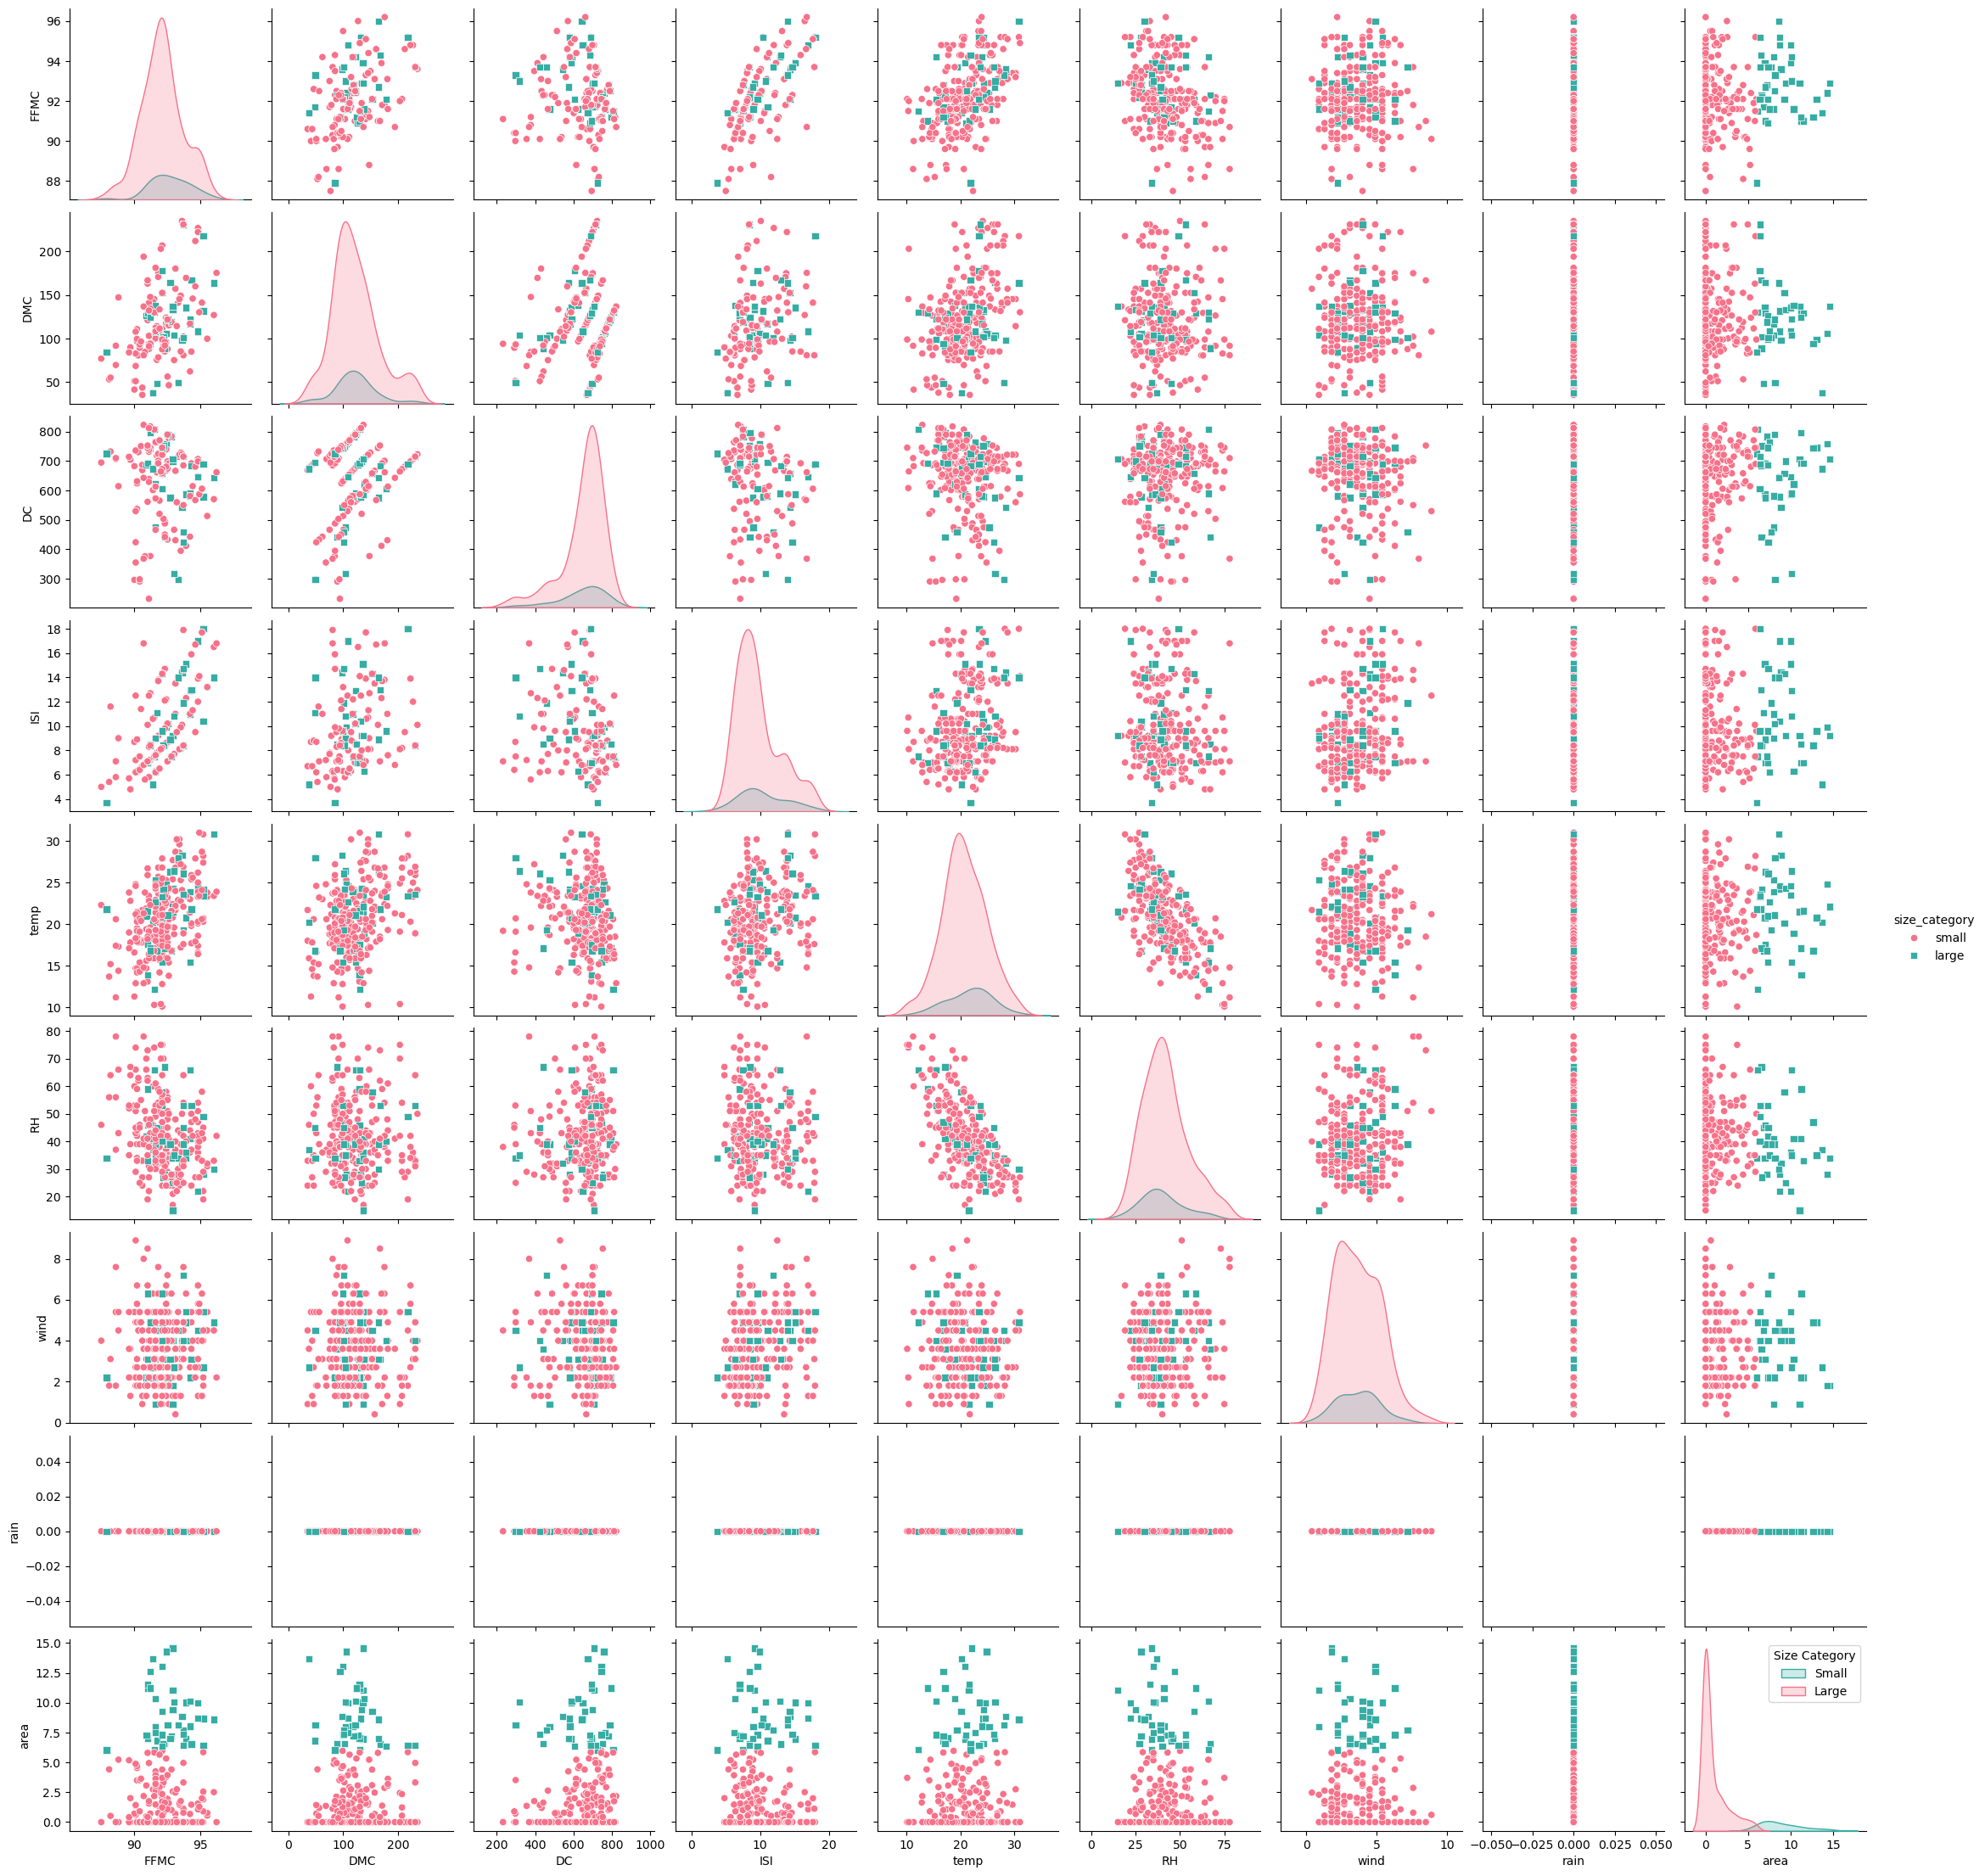

In [6]:
# Pairplot for numerical features
sns.pairplot(data[numerical_features + ['size_category']], hue='size_category', markers=['o', 's'], palette='husl')
plt.legend(title='Size Category', loc='upper right', labels=['Small', 'Large'])
plt.show()

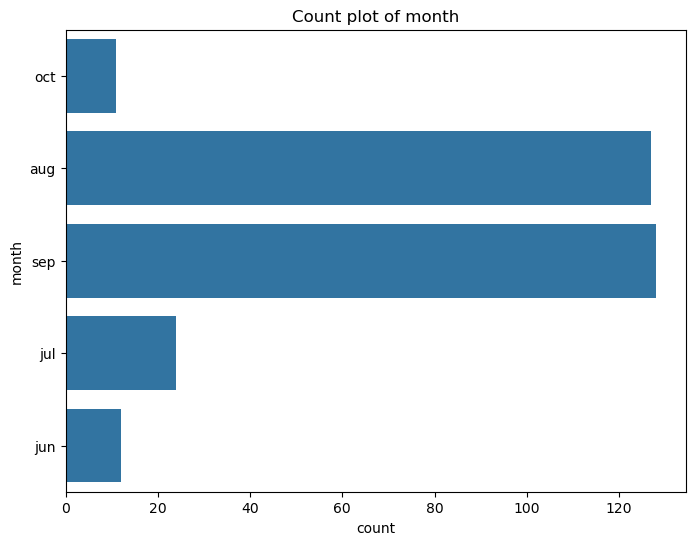

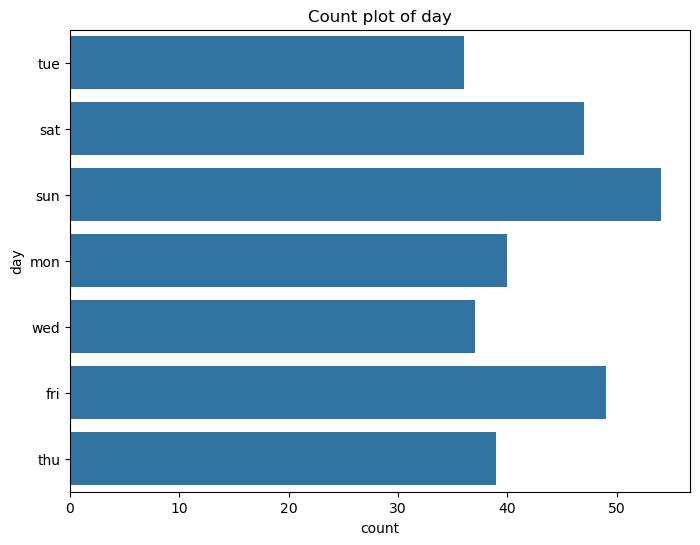

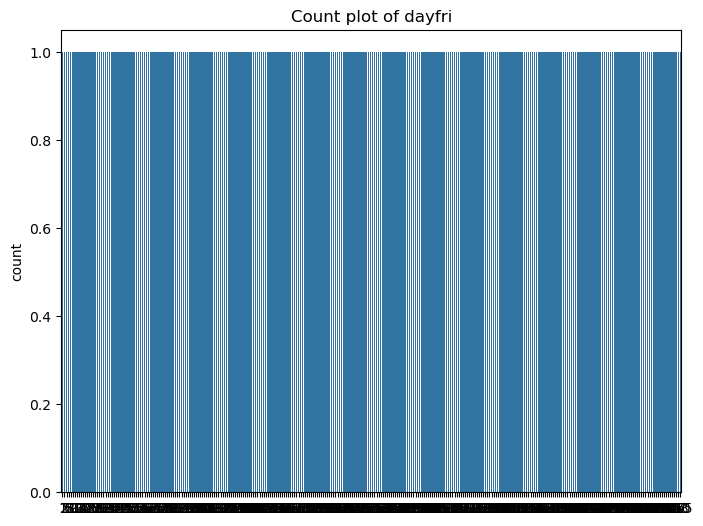

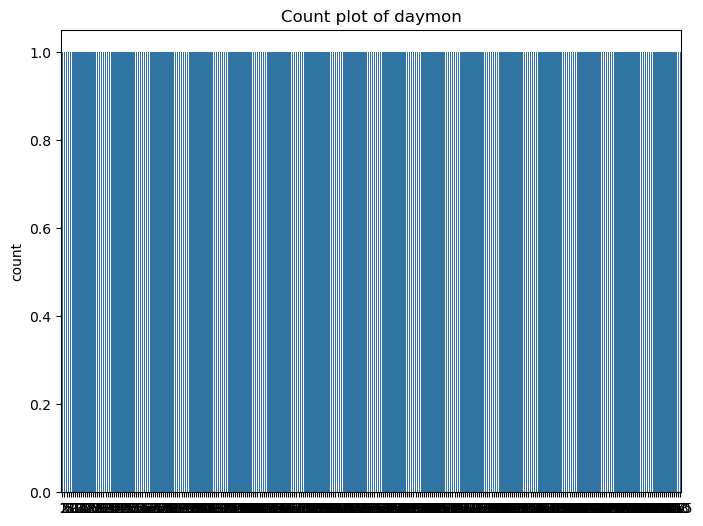

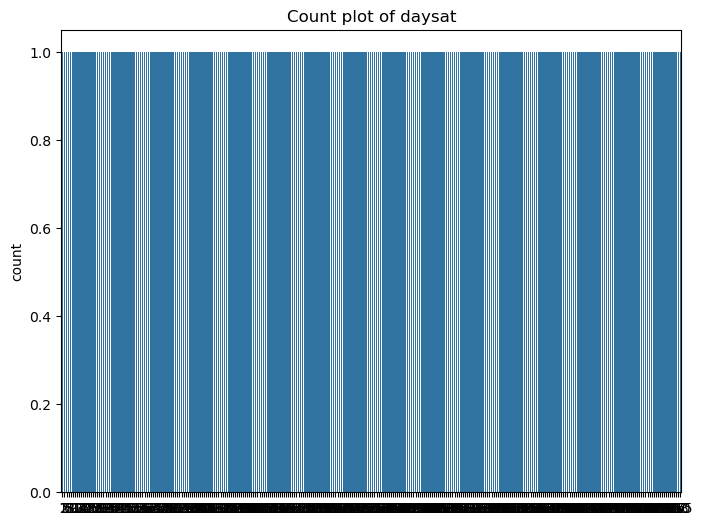

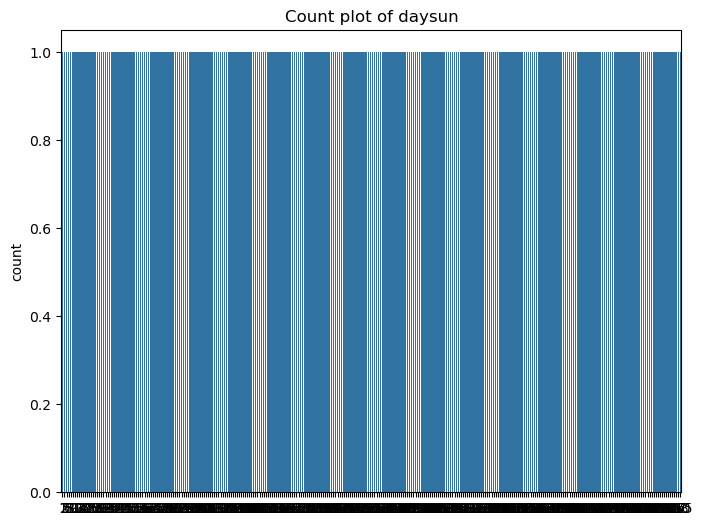

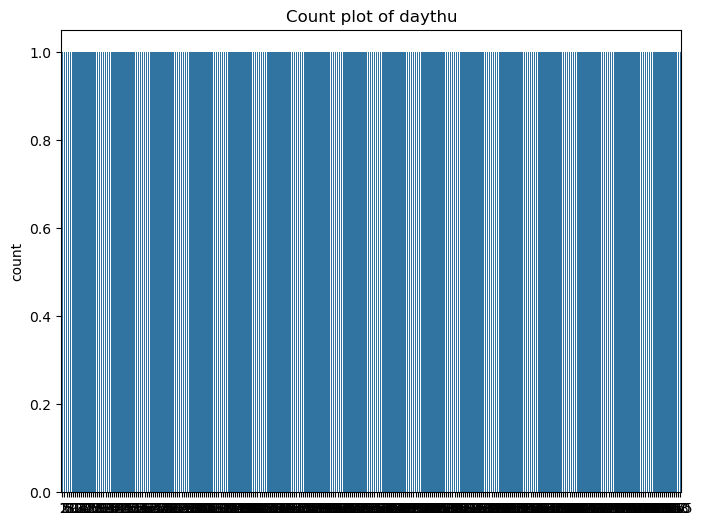

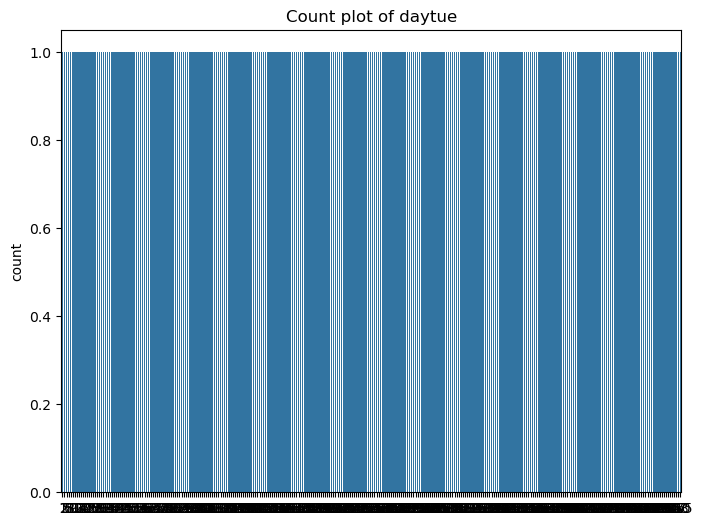

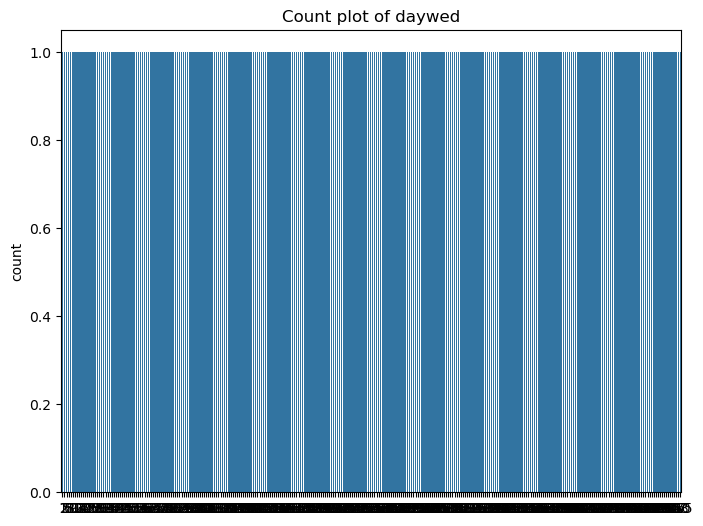

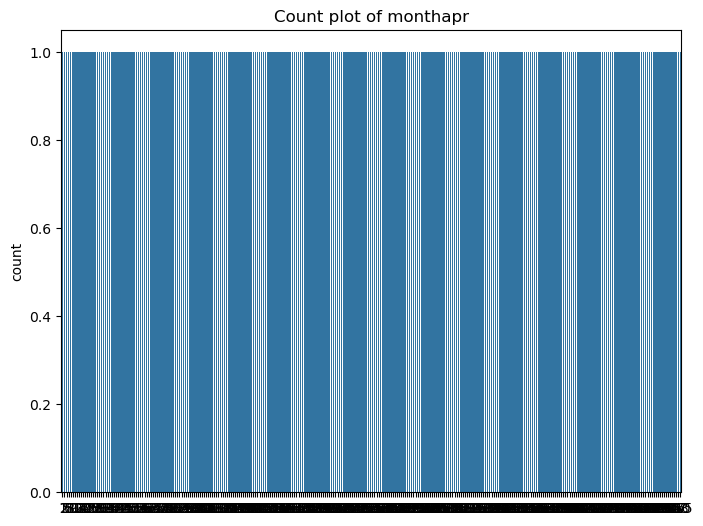

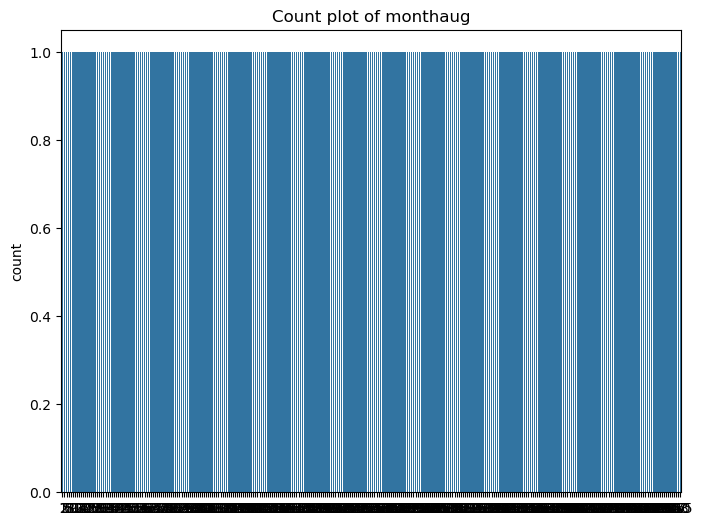

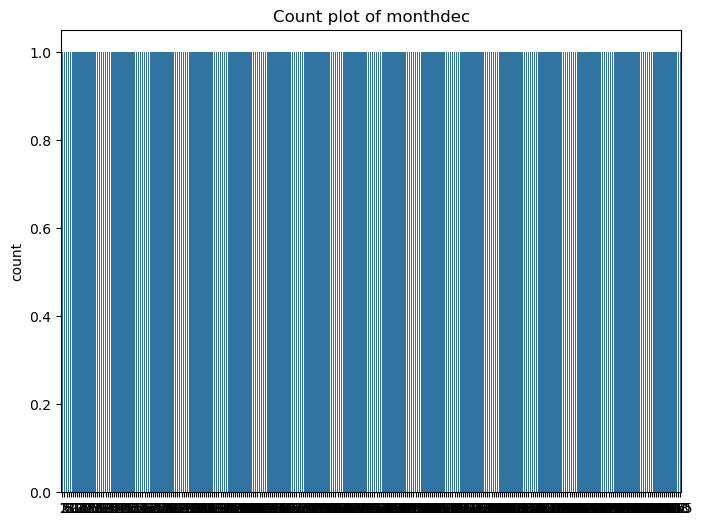

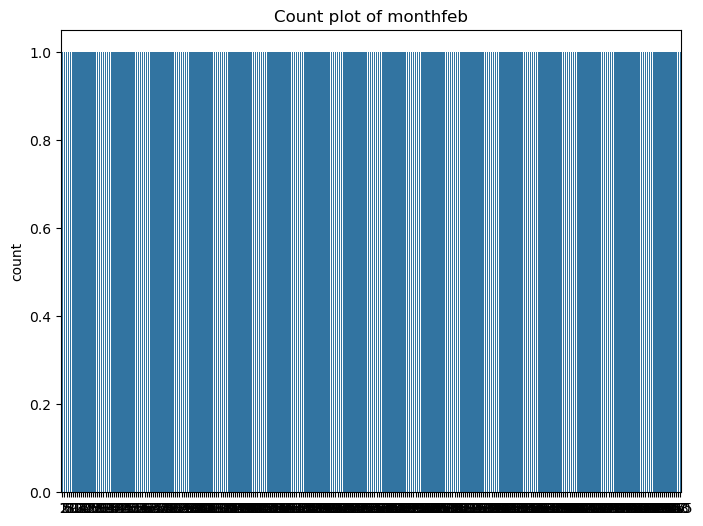

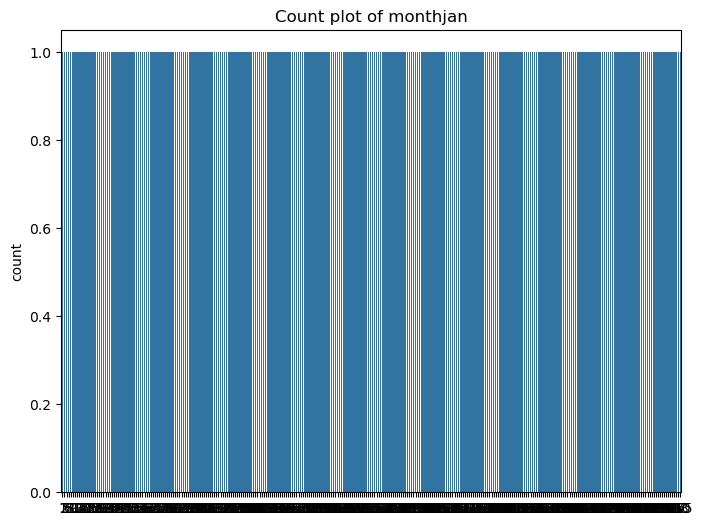

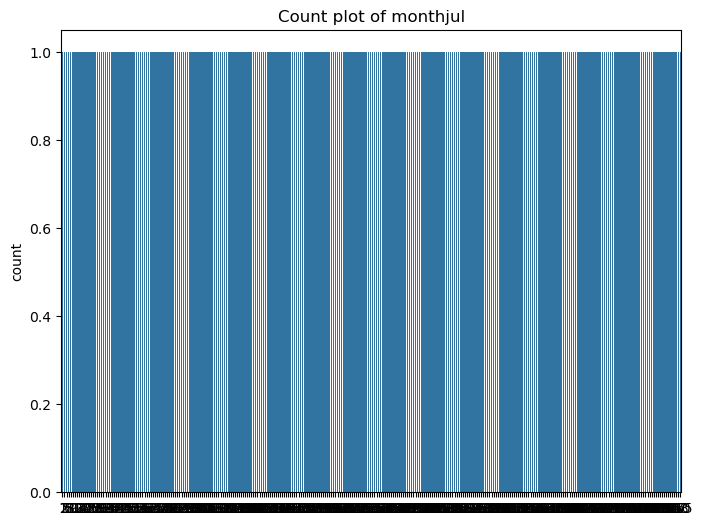

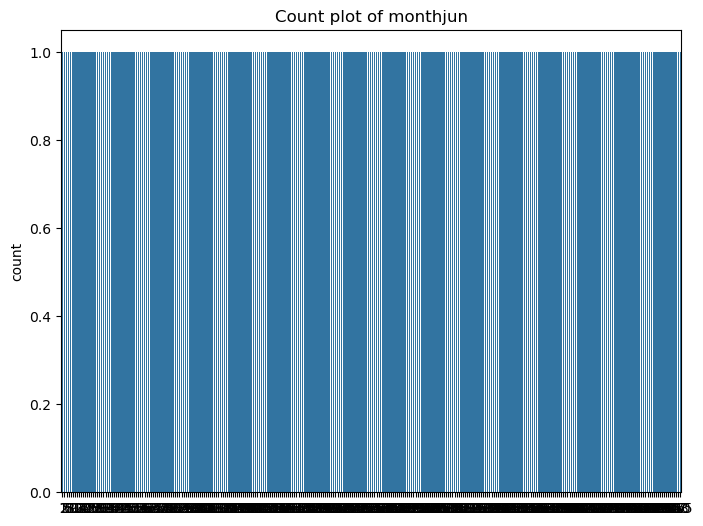

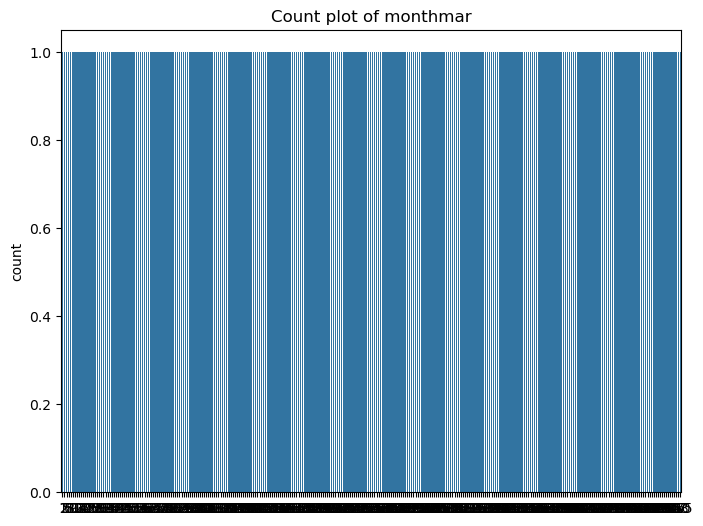

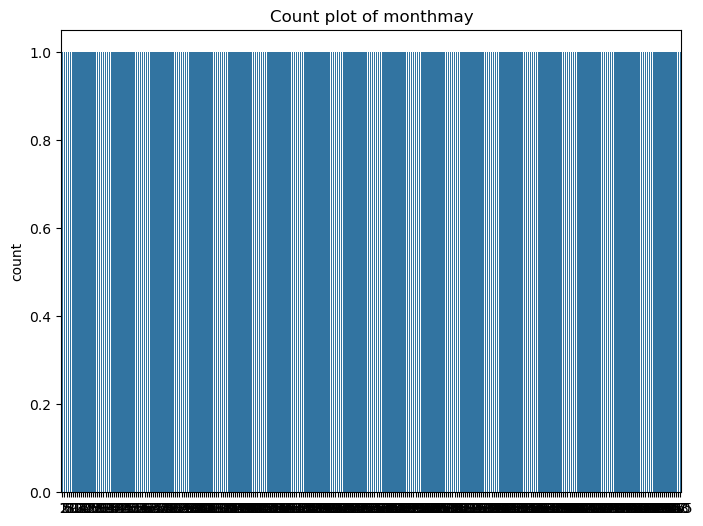

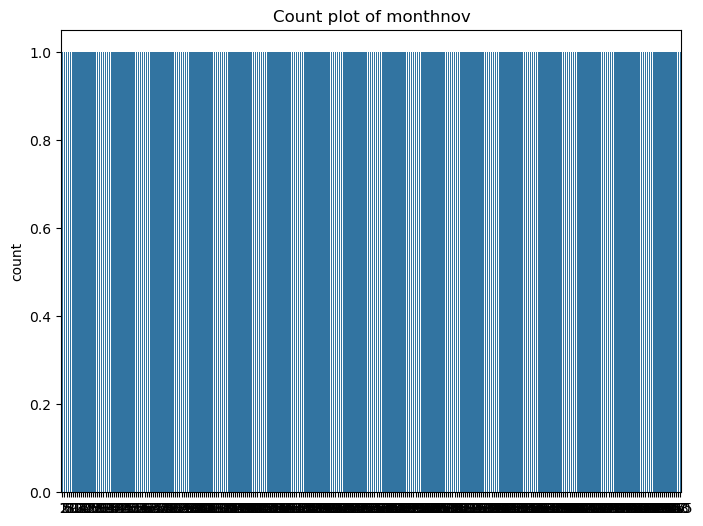

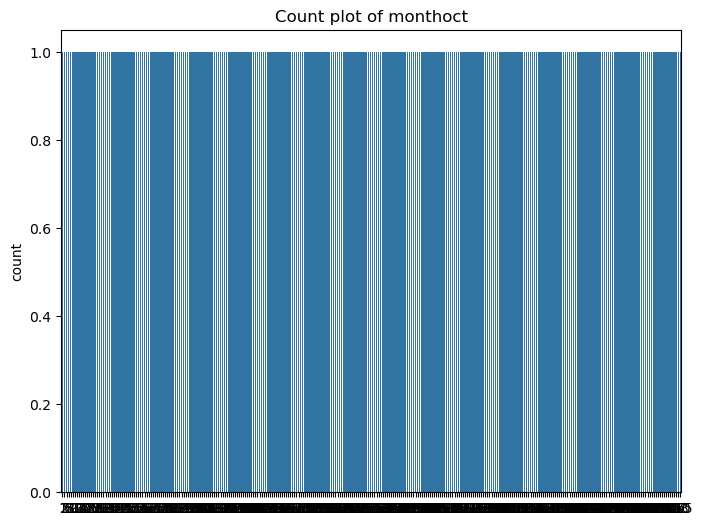

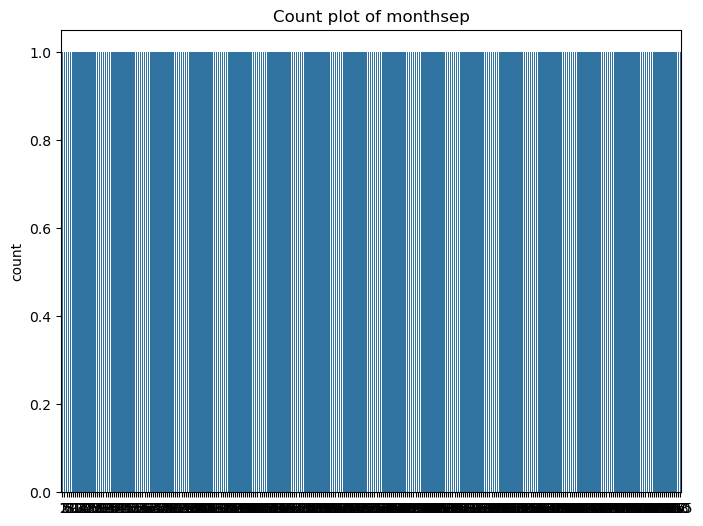

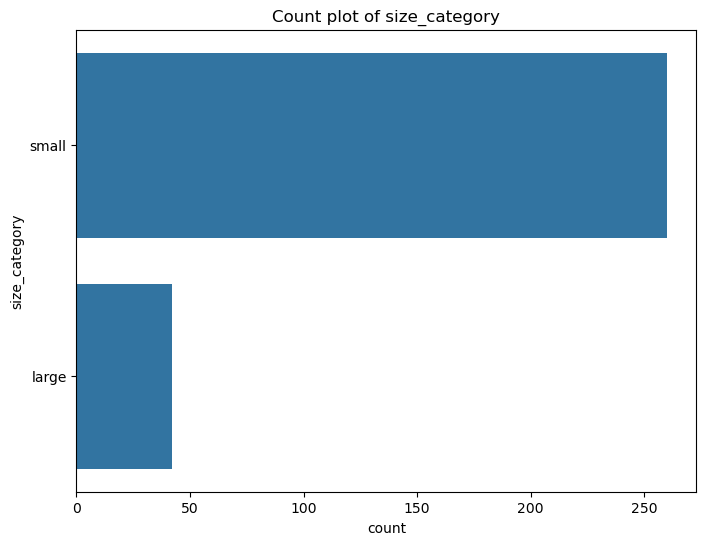

In [7]:
# Count plot for categorical features
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data[feature])
    plt.title(f'Count plot of {feature}')
    plt.show()

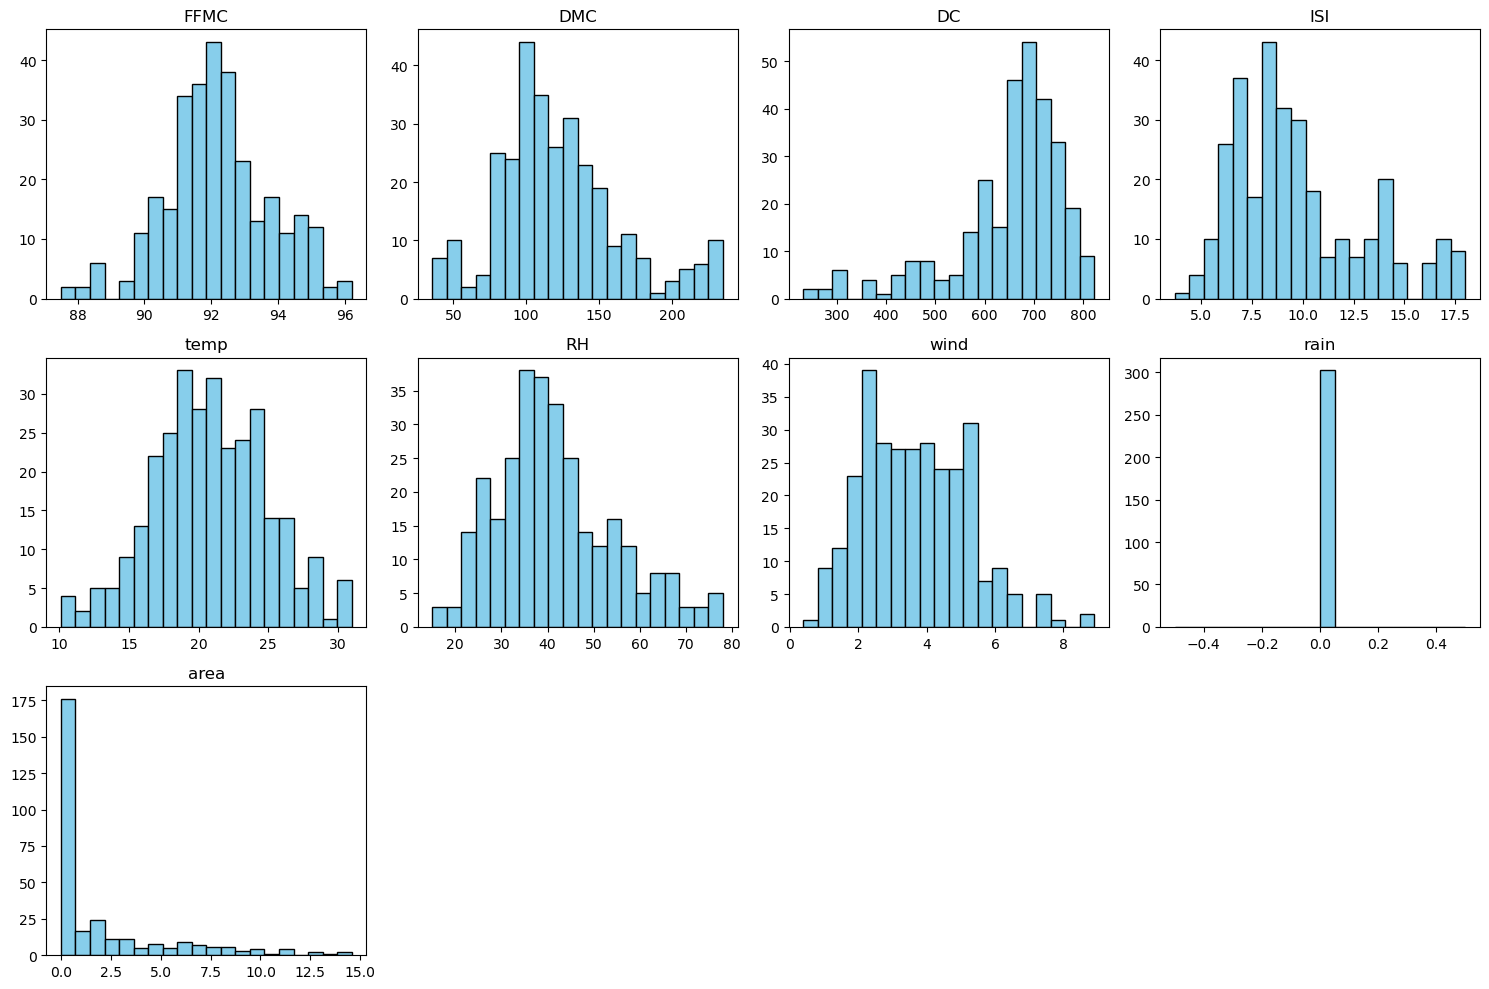

In [8]:
plt.figure(figsize=(15, 10))
num_features = len(numerical_features)
num_rows = (num_features + 3) // 4
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, 4, i+1)
    plt.hist(data[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(feature)
plt.tight_layout()
plt.show()

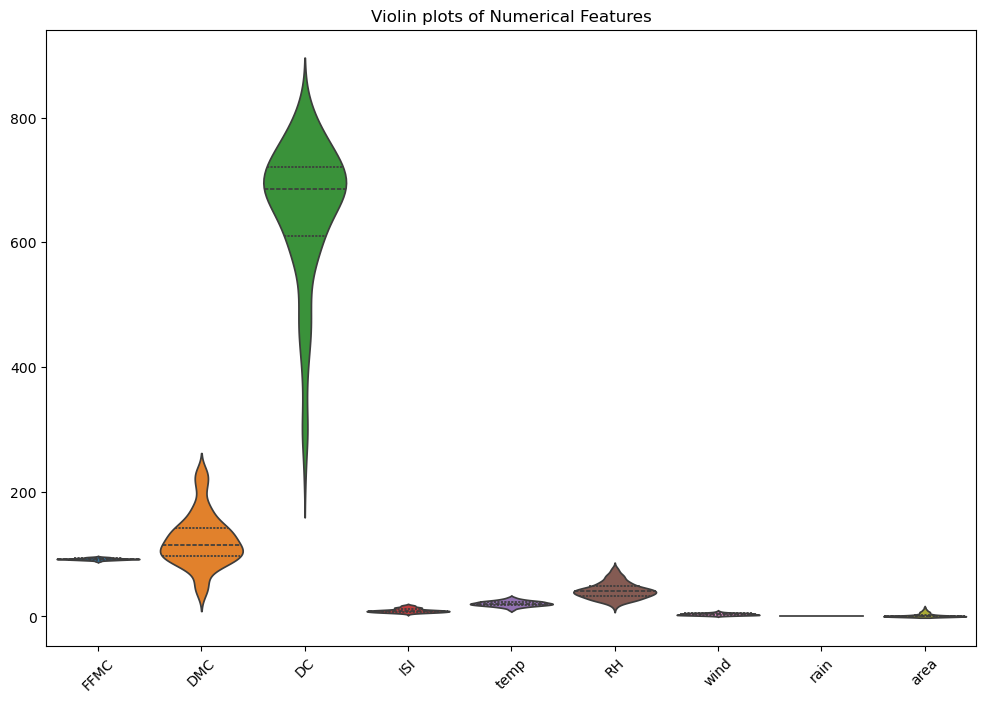

In [9]:
# Violin plots for numerical features
plt.figure(figsize=(12, 8))
sns.violinplot(data=data[numerical_features], inner='quartile')
plt.title('Violin plots of Numerical Features')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Encode categorical variables
encoder = LabelEncoder()
data['month'] = encoder.fit_transform(data['month'])
data['day'] = encoder.fit_transform(data['day'])
data['size_category'] = encoder.fit_transform(data['size_category'])

# Split features and target variable
X = data.drop(columns=['size_category'])
y = data['size_category']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Define the SVM model
svm_model = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    # Regularization parameter
    'C': [0.1, 1, 10, 100],
    # Kernel type
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'gamma': ['scale', 'auto']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found by grid search:")
print(grid_search.best_params_)

accuracy = grid_search.score(X_test, y_test)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))

Best parameters found by grid search:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy on test set: 96.72%


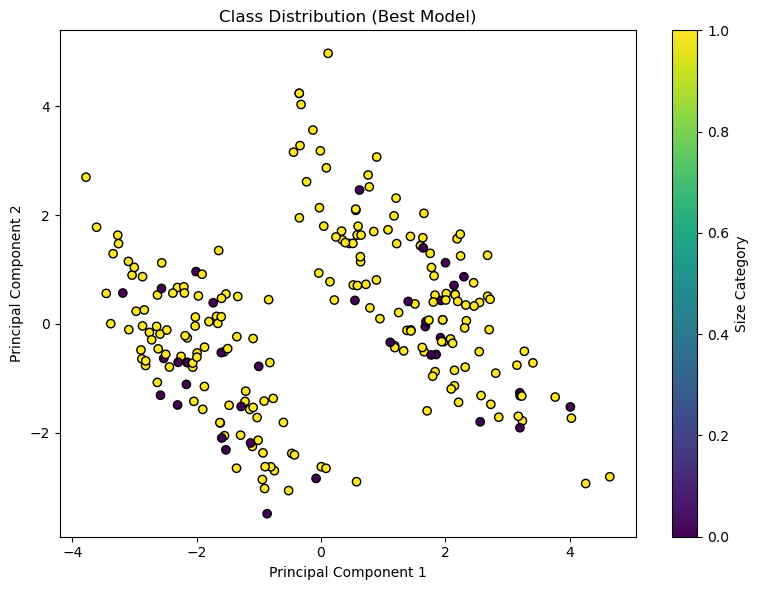

In [15]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Visualize class distribution in reduced-dimensional space
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', marker='o', edgecolors='k')
plt.title(f'Class Distribution (Best Model)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Size Category')
plt.tight_layout()
plt.show()